# 21st april notebook

## Covering "How PyTorch organizes data"

In [1]:
# importing libraries
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as ans

### Datasets

In [2]:
# Creating some data in numpy
npoints = 100
nfeatures = 20
data_np = np.random.randn(npoints, nfeatures)

In [3]:
# Converting numpy data to torch.tensors
data = torch.tensor(data_np)

In [4]:
data.shape, data.dtype, type(data)

(torch.Size([100, 20]), torch.float64, torch.Tensor)

In [5]:
# Converting torch tensors to torch datasets
dataset = TensorDataset(data)
dataset.tensors

(tensor([[ 2.2191, -0.2543, -1.1140,  ...,  0.8741,  0.9507, -0.0495],
         [ 0.2234,  1.9499, -1.1708,  ..., -0.7586, -0.0202, -0.8472],
         [-0.1041, -0.2693,  1.1390,  ...,  1.0901, -1.1563,  0.5828],
         ...,
         [ 0.0828, -0.2971, -0.5272,  ...,  0.4783,  2.8663,  1.0228],
         [-0.3998,  1.5916,  0.6699,  ..., -1.0414, -2.6106, -1.0101],
         [ 0.7684, -1.7402,  1.2033,  ...,  1.5385,  0.7177, -0.1945]],
        dtype=torch.float64),)

In [6]:
# Creating labels
labels = torch.ceil(torch.linspace(0.1, 4, npoints))

# Convertign labels into matrix
labels = labels.reshape((len(labels), 1))

# making complete dataset
dataset = TensorDataset(data, labels)

In [7]:
dataset.tensors[0].shape

torch.Size([100, 20])

### DataLoaders

In [8]:
# Creating dataLoaders
batch_size = 20
dataLoaders = DataLoader(dataset, batch_size=batch_size,
                         shuffle=True)
dataLoaders.dataset.tensors[0].shape

torch.Size([100, 20])

In [9]:
for x, y in dataLoaders:
  print(x.shape, y.shape)

torch.Size([20, 20]) torch.Size([20, 1])
torch.Size([20, 20]) torch.Size([20, 1])
torch.Size([20, 20]) torch.Size([20, 1])
torch.Size([20, 20]) torch.Size([20, 1])
torch.Size([20, 20]) torch.Size([20, 1])


## Data size and network size

In [50]:
def createData(points):
    a = [1, 1]
    b = [5, 1]
    c = [4, 4]

    # Generating data
    a = [a[0] + np.random.randn(points), a[1] + np.random.randn(points)]
    b = [b[0] + np.random.randn(points), b[1] + np.random.randn(points)]
    c = [c[0] + np.random.randn(points), c[1] + np.random.randn(points)]

    labels_np = np.hstack((np.zeros((points)),
                         np.ones((points)),
                         1 + np.ones((points))
                         ))
    data_np = np.hstack((a, b, c)).T
    op = {}
    op["data"] = torch.tensor(data_np).float()
    op["labels"] = torch.tensor(labels_np).long()

    train_data, test_data, train_labels, test_labels = train_test_split(op["data"],
                                                                      op["labels"],
                                                                      test_size=0.2)
    train_data = TensorDataset(train_data, train_labels)
    test_data = TensorDataset(test_data, test_labels)

    batch_size = 32
    op["train_data"] = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
    op["test_data"] = DataLoader(test_data,
                                batch_size=test_data.tensors[0].shape[0])
    return op

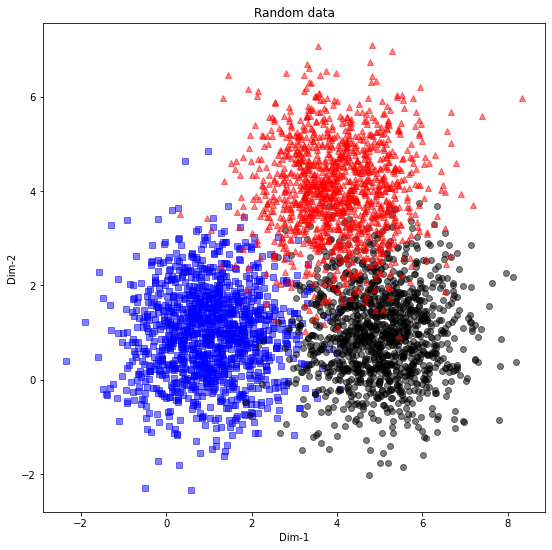

In [51]:
dataset = createData(1200)
data = dataset["data"]
labels = dataset["labels"]

fig = plt.figure(figsize=(9, 9))
plt.plot(data[np.where(labels==0)[0], 0], data[np.where(labels==0)[0],1],
        "bs", alpha=.5)
plt.plot(data[np.where(labels==1)[0], 0], data[np.where(labels==1)[0],1],
        "ko", alpha=.5)
plt.plot(data[np.where(labels==2)[0], 0], data[np.where(labels==2)[0],1],
        "r^", alpha=.5)
plt.title("Random data")
plt.xlabel("Dim-1")
plt.ylabel("Dim-2");

### Creating the model

In [52]:
def createModel(nUnits, nLayers):
    class annModel(nn.Module):
        def __init__(self, nu, nl):
            super().__init__()
            # Input layer and init data
            self.layers = nn.ModuleDict()
            self.layer_counts = nl
            self.layers["input"] = nn.Linear(2, nu)
            
            for i in range(nl):
                self.layers[f"hidden_{i}"] = nn.Linear(nu, nu)
            
            # output layer
            self.layers["output"] = nn.Linear(nu, 3)
        
        # forward pass
        def forward(self, x):
            x = self.layers["input"](x)
            for i in range(self.layer_counts):
                x = F.relu(self.layers[f"hidden_{i}"](x))
            x = self.layers["output"](x)
            return x
    # getting ann model
    model = annModel(nUnits, nLayers)
    # setting up loss functions
    Loss = nn.CrossEntropyLoss()
    # optim
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    return model, optimizer, Loss

In [53]:
# fake data test
nu = 12
nl = 4
model, optimizer, Loss = createModel(nu, nl)
fake_data = torch.rand(4, 2)
model(fake_data)

tensor([[ 0.2137, -0.1971, -0.1792],
        [ 0.2174, -0.2014, -0.1771],
        [ 0.2141, -0.1978, -0.1788],
        [ 0.2131, -0.1978, -0.1778]], grad_fn=<AddmmBackward0>)

In [54]:
def train_model_1(nu, nl, epochs=100):
    model, optimizer, Loss = createModel(nu, nl)
    losses = []
    train_acc = []
    test_acc = []
    
    for i in range(epochs):
        batch_acc = []
        batch_loss = []
        for x, y in dataset["train_data"]:
            # Forward pass
            yh = model(y)
            loss = Loss(yh, y)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Computing
            batch_loss.append(loss)
            correct = (torch.argmax(yh) == y).float()
            batch_acc.append(100 * torch.mean(correct))
        train_acc.append(np.mean(batch_acc))
        losses.append(np.mean(batch_loss))
        x, y = next(iter(op["test_data"]))
        with torch.no_grad():
            yh = model(x)
        correct = (torch.argmax(yh) == y).float()
        test_acc.append(100 * torch.mean(correct))
    return model, train_acc, test_acc, train_loss

In [ ]:
model, train_acc, test_acc, train_loss = train_model_1(80, 1)

In [38]:
dataset["data"]

tensor([[-0.1146,  1.4829],
        [ 1.2389,  2.5871],
        [ 3.1699, -0.9945],
        ...,
        [ 4.2069,  2.7577],
        [ 4.8449,  4.6101],
        [ 4.8518,  4.1978]])